In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/network-anamoly-detection/Network Anamoly Detection.docx
/kaggle/input/network-anamoly-detection/Test.txt
/kaggle/input/network-anamoly-detection/Train.txt


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import multiprocessing
import itertools
import warnings

from collections import Counter
from pandas.api.types import is_numeric_dtype

# Machine Learning Models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    ExtraTreesClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# # Deep Learning (TensorFlow/Keras)
# import tensorflow as tf
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Dense, Dropout

# Metrics & Evaluation
from sklearn.metrics import (
    accuracy_score, confusion_matrix, precision_score, recall_score, 
    f1_score, roc_auc_score, classification_report, precision_recall_curve,
    r2_score, mean_squared_error
)

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE, ADASYN

# Suppress warnings
warnings.filterwarnings("ignore")


# Load & Read The Train Data

In [2]:
df = pd.read_csv("/Users/puneetgani/Documents/hackathon/netsentry/modelBuilding/archive/Train.txt",sep=",",names=["duration","protocoltype","service","flag","srcbytes","dstbytes","land", "wrongfragment","urgent","hot","numfailedlogins","loggedin", "numcompromised","rootshell","suattempted","numroot","numfilecreations", "numshells","numaccessfiles","numoutboundcmds","ishostlogin",
"isguestlogin","count","srvcount","serrorrate", "srvserrorrate",
"rerrorrate","srvrerrorrate","samesrvrate", "diffsrvrate", "srvdiffhostrate","dsthostcount","dsthostsrvcount","dsthostsamesrvrate", "dsthostdiffsrvrate","dsthostsamesrcportrate",
"dsthostsrvdiffhostrate","dsthostserrorrate","dsthostsrvserrorrate",
"dsthostrerrorrate","dsthostsrvrerrorrate","attack", "lastflag"])
df.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,...,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [3]:
df.shape

(125973, 43)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   duration                125973 non-null  int64  
 1   protocoltype            125973 non-null  object 
 2   service                 125973 non-null  object 
 3   flag                    125973 non-null  object 
 4   srcbytes                125973 non-null  int64  
 5   dstbytes                125973 non-null  int64  
 6   land                    125973 non-null  int64  
 7   wrongfragment           125973 non-null  int64  
 8   urgent                  125973 non-null  int64  
 9   hot                     125973 non-null  int64  
 10  numfailedlogins         125973 non-null  int64  
 11  loggedin                125973 non-null  int64  
 12  numcompromised          125973 non-null  int64  
 13  rootshell               125973 non-null  int64  
 14  suattempted         

In [5]:
df.describe()

,duration,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,...,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240,19.504060
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459,2.291503
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


As we can see 'land', 'urgent', 'numfailedlogins', 'numoutboundcmds' have mostly zero values so we can drop these columns.

In [6]:
# Drop unnecessary columns
df.drop(['land','urgent','numfailedlogins','numoutboundcmds'],axis=1,inplace=True)

In [7]:
df.isna().sum()

duration                  0
protocoltype              0
service                   0
flag                      0
srcbytes                  0
dstbytes                  0
wrongfragment             0
hot                       0
loggedin                  0
numcompromised            0
rootshell                 0
suattempted               0
numroot                   0
numfilecreations          0
numshells                 0
numaccessfiles            0
ishostlogin               0
isguestlogin              0
count                     0
srvcount                  0
serrorrate                0
srvserrorrate             0
rerrorrate                0
srvrerrorrate             0
samesrvrate               0
diffsrvrate               0
srvdiffhostrate           0
dsthostcount              0
dsthostsrvcount           0
dsthostsamesrvrate        0
dsthostdiffsrvrate        0
dsthostsamesrcportrate    0
dsthostsrvdiffhostrate    0
dsthostserrorrate         0
dsthostsrvserrorrate      0
dsthostrerrorrate   

In [8]:
df.select_dtypes(exclude=[np.number])

,protocoltype,service,flag,attack
0,tcp,ftp_data,SF,normal
1,udp,other,SF,normal
2,tcp,private,S0,neptune
3,tcp,http,SF,normal
4,tcp,http,SF,normal
...,...,...,...,...
125968,tcp,private,S0,neptune
125969,udp,private,SF,normal
125970,tcp,smtp,SF,normal
125971,tcp,klogin,S0,neptune


For focussing on Binomial Classification for this dataset, we can make all other classes other than normal as 'attack'.

In [9]:
df['attack'].loc[df['attack']!='normal']='attack'

In [10]:
le=LabelEncoder()

In [11]:
df['protocoltype']=le.fit_transform(df['protocoltype'])
df['service']=le.fit_transform(df['service'])
df['flag']=le.fit_transform(df['flag'])
df['attack']=le.fit_transform(df['attack'])

# Correlation Matrix

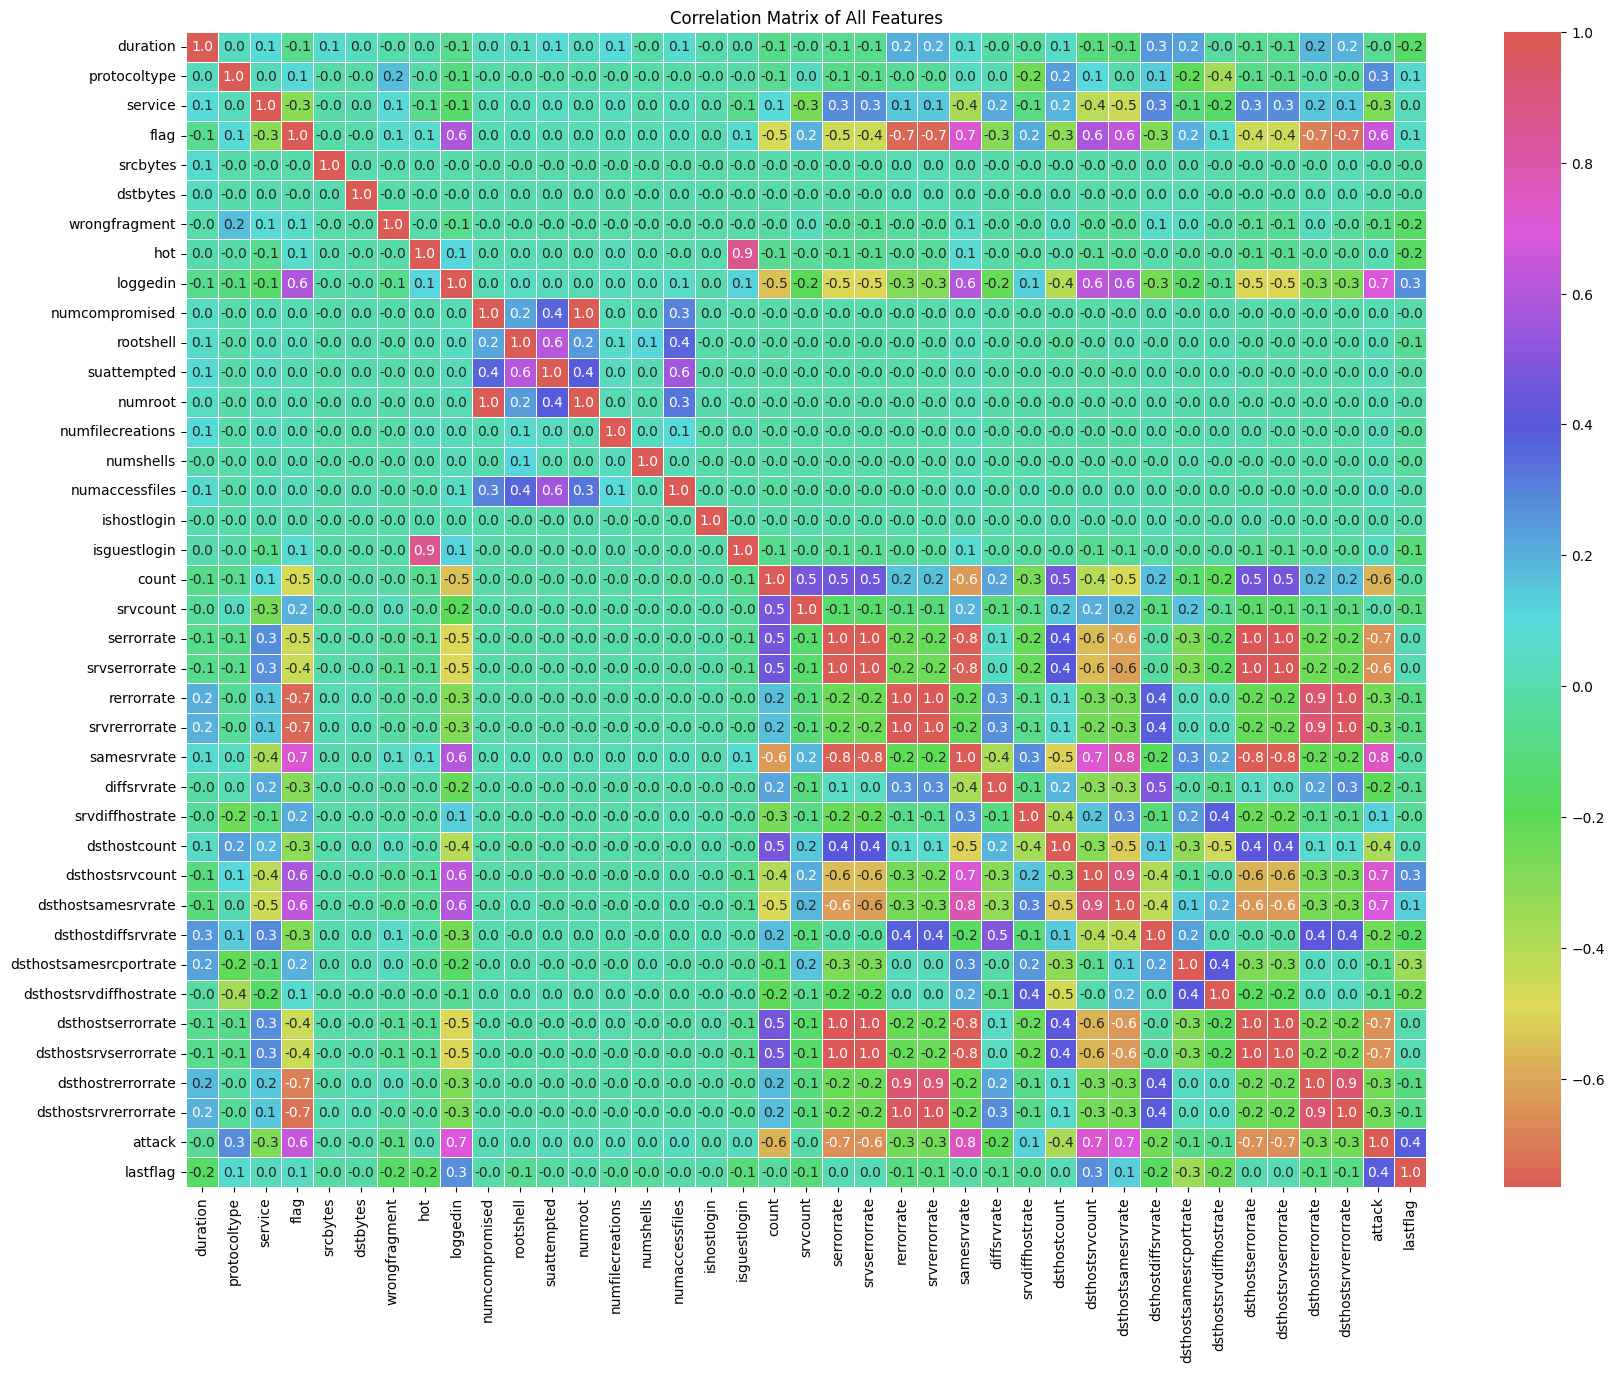

In [12]:
# Calculate the correlation matrix
corr_matrix = df.corr(numeric_only=True)

cmap_husl = sns.hls_palette(as_cmap=True)
#cmap_husl = sns.husl_palette(as_cmap=True)

# Plot the correlation matrix with values using the Husl colormap
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, fmt=".1f", cmap=cmap_husl, linewidths=0.5)
plt.title('Correlation Matrix of All Features')
plt.show()

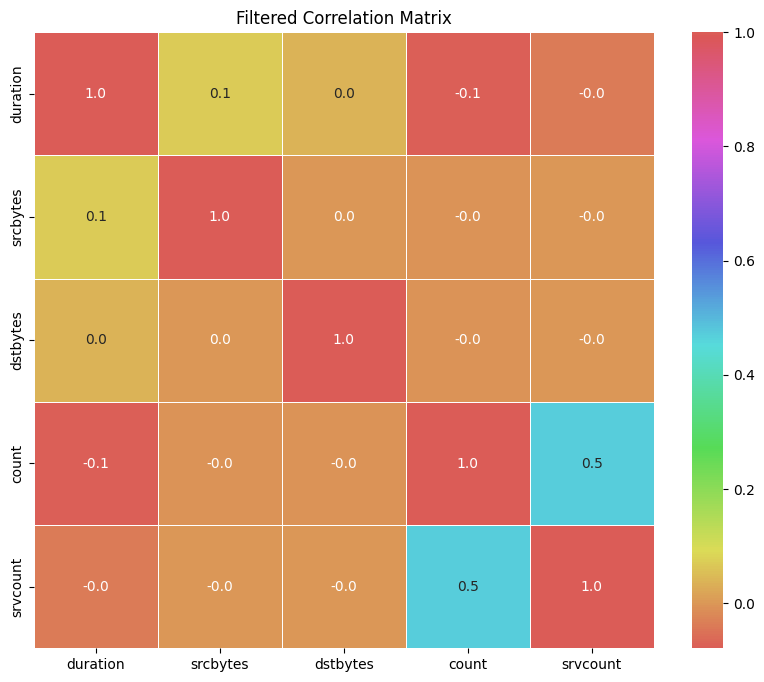

In [13]:
# Filter the correlation matrix for specific features
selected_features = ['duration', 'srcbytes', 'dstbytes', 'count', 'srvcount']
filtered_corr_matrix = df[selected_features].corr()

# Plot the filtered correlation matrix
plt.figure(figsize=(10, 8))
cmap_husl = sns.hls_palette(as_cmap=True)
sns.heatmap(filtered_corr_matrix, annot=True, fmt=".1f", cmap= cmap_husl, linewidths=0.5)
plt.title('Filtered Correlation Matrix')
plt.show()

In [14]:
X=df.drop(['attack'],axis=1)
y=df['attack']

In [ ]:
sns.countplot(df['attack'])

<Axes: ylabel='count'>

Error in callback <function _draw_all_if_interactive at 0x319568040> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [17]:
print("Class distribution: {}".format(Counter(y)))

Class distribution: Counter({1: 67343, 0: 58630})


# Implementing Classification Models for Train Data

* **Tree-based Models:** Random Forest, Decision Tree, Extreme Gradient Boosting (XGBoost)

* **Linear or Kernel-based Models:** Support Vector Machine (SVM), Logistic Regression, K-Nearest Neighbors (KNN)

* **Sequence or Spatial Neural Network-Based Models:** CNN (Convolutional Neural Network) & RNN (Recurrent Neural Network)

* **Fully Connected or Feedforward Neural Network-Based Models:** ANN (Artificial Neural Network)	& MLP (Multilayer Perceptron)

In [18]:
scaler = StandardScaler()
scaler.fit(X)
X_transformed = scaler.transform(X)

# Initialize and Train the Machine Learning (ML) Models

**Using Random Forest**

In [19]:
# RF Model Creation
rf=RandomForestClassifier() 
rf.fit(X_transformed,y)

RandomForestClassifier()

**Using DT**

In [20]:
# DT Model Creation
dt = DecisionTreeClassifier()
dt.fit(X_transformed, y)

DecisionTreeClassifier()

**Using XGBoost**

In [21]:
# XGB Model Creation
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_transformed, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

**Using SVM**

In [22]:
# SVM Model Creation
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_transformed, y)

SVC(random_state=42)

**Using Logistic Regression**

In [23]:
# LR Model Creation
lr=LogisticRegression()  
lr.fit(X_transformed,y)

LogisticRegression()

**Using Knn**

In [24]:
# KNN Model Creation
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_transformed, y)

KNeighborsClassifier()

**Model Predictions**

In [25]:
# RF Model Predictions
rf_pred=rf.predict(X_transformed)

# DT Model Predictions
dt_pred=dt.predict(X_transformed)

# XGB Model Predictions
xgb_pred=xgb.predict(X_transformed)


# SVM Model Predictions
svm_pred=svm.predict(X_transformed)

# LR Model Predictions
lr_pred=lr.predict(X_transformed)

# KNN Model Predictions
knn_pred=knn.predict(X_transformed)

**Prediction DataFrame (actual vs pred)**

In [26]:
def get_prediction_df(model_name, model, X, y):
    print(f"\n====== {model_name} Prediction DataFrame ======")
    y_pred = model.predict(X)
    pred_df = pd.DataFrame({'actual': y, 'pred': y_pred})
    print(pred_df.head())
    return pred_df


rf_df = get_prediction_df("Random Forest", rf, X_transformed, y)
dt_df  = get_prediction_df("Decision Tree", dt, X_transformed, y)
xgb_df = get_prediction_df("XGBoost", xgb, X_transformed, y)

svm_df = get_prediction_df("SVM", svm, X_transformed, y)
lr_df = get_prediction_df("Logistic Regression", lr, X_transformed, y)
knn_df = get_prediction_df("K-Nearest Neighbors", knn, X_transformed, y)


====== Random Forest Prediction DataFrame ======
   actual  pred
0       1     1
1       1     1
2       0     0
3       1     1
4       1     1

====== Decision Tree Prediction DataFrame ======
   actual  pred
0       1     1
1       1     1
2       0     0
3       1     1
4       1     1

====== XGBoost Prediction DataFrame ======
   actual  pred
0       1     1
1       1     1
2       0     0
3       1     1
4       1     1

====== SVM Prediction DataFrame ======
   actual  pred
0       1     1
1       1     0
2       0     0
3       1     1
4       1     1

====== Logistic Regression Prediction DataFrame ======
   actual  pred
0       1     1
1       1     0
2       0     0
3       1     1
4       1     1

====== K-Nearest Neighbors Prediction DataFrame ======
   actual  pred
0       1     1
1       1     1
2       0     0
3       1     1
4       1     1


**ML Evaluation on Training Data**

In [27]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_ml_model(y, y_pred, model_name="Model"):
    print(f"\n{'='*30} {model_name} Training Evaluation {'='*30}\n")
    
    print("Accuracy:", accuracy_score(y, y_pred))
    print("\nClassification Report:")
    print(classification_report(y, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y, y_pred))

    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print("\nConfusion Matrix Parameters:")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")


evaluate_ml_model(y, rf_pred, "Random Forest")
evaluate_ml_model(y, dt_pred, "Decision Tree")
evaluate_ml_model(y, xgb_pred, "XGBoost")


evaluate_ml_model(y, svm_pred, "SVM")
evaluate_ml_model(y, lr_pred, "Logistic Regression")
evaluate_ml_model(y, knn_pred, "KNN")


============================== Random Forest Training Evaluation ==============================

Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58630
           1       1.00      1.00      1.00     67343

    accuracy                           1.00    125973
   macro avg       1.00      1.00      1.00    125973
weighted avg       1.00      1.00      1.00    125973


Confusion Matrix:
[[58630     0]
 [    0 67343]]

Confusion Matrix Parameters:
True Negatives (TN): 58630
False Positives (FP): 0
False Negatives (FN): 0
True Positives (TP): 67343

============================== Decision Tree Training Evaluation ==============================

Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58630
           1       1.00      1.00      1.00     67343

    accuracy                           1.00    125973
 

# Build the Deep Learning (DL) Models

In [28]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Reshape data for DL models
X_reshaped_cnn = np.expand_dims(X_transformed, axis=-1)  # For CNN
X_reshaped_rnn = X_transformed.reshape(X_transformed.shape[0], 1, X_transformed.shape[1])  # For RNN

**Using CNN**

In [29]:
cnn_model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_transformed.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.3),
    Conv1D(128, 3, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer=Adam(0.001), 
                loss='binary_crossentropy', 
                metrics=['accuracy'])

# Train CNN
cnn_history = cnn_model.fit(X_reshaped_cnn, y,
                          epochs=20,
                          batch_size=256,
                          validation_split=0.2,
                          callbacks=[EarlyStopping(patience=3)],
                          verbose=1)

Epoch 1/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.9773 - loss: 0.0597 - val_accuracy: 0.9961 - val_loss: 0.0167
Epoch 2/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.9956 - loss: 0.0130 - val_accuracy: 0.9975 - val_loss: 0.0078
Epoch 3/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.9967 - loss: 0.0094 - val_accuracy: 0.9976 - val_loss: 0.0067
Epoch 4/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.9970 - loss: 0.0084 - val_accuracy: 0.9985 - val_loss: 0.0053
Epoch 5/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.9974 - loss: 0.0066 - val_accuracy: 0.9970 - val_loss: 0.0063
Epoch 6/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.9977 - loss: 0.0059 - val_accuracy: 0.9982 - val_loss: 0.0051
Epoch 7/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9979 - loss: 0.0052 - val_accuracy: 0.9978 - val_loss: 0.0060
Epoch 8/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.9975 - loss: 0.0071 - 

**Using RNN**

In [30]:
rnn_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(1, X_transformed.shape[1])),
    Dropout(0.3),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(optimizer=Adam(0.0005), 
                loss='binary_crossentropy', 
                metrics=['accuracy'])

# Train RNN
rnn_history = rnn_model.fit(X_reshaped_rnn, y,
                          epochs=20,
                          batch_size=256,
                          validation_split=0.2,
                          callbacks=[EarlyStopping(patience=3)],
                          verbose=1)

Epoch 1/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9069 - loss: 0.3782 - val_accuracy: 0.9909 - val_loss: 0.0306
Epoch 2/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9903 - loss: 0.0289 - val_accuracy: 0.9955 - val_loss: 0.0159
Epoch 3/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9936 - loss: 0.0176 - val_accuracy: 0.9957 - val_loss: 0.0122
Epoch 4/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9950 - loss: 0.0134 - val_accuracy: 0.9968 - val_loss: 0.0107
Epoch 5/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9958 - loss: 0.0112 - val_accuracy: 0.9962 - val_loss: 0.0101
Epoch 6/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9957 - loss: 0.0107 - val_accuracy: 0.9963 - val_loss: 0.0095
Epoch 7/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9956 - loss: 0.0102 - val_accuracy: 0.9962 - val_loss: 0.0093
Epoch 8/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9966 - loss: 0.0091 - val_accuracy: 0.

**Using ANN**

In [31]:
ann_model = Sequential([
    Dense(256, activation='relu', input_dim=X_transformed.shape[1]),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

ann_model.compile(optimizer=Adam(0.001), 
                loss='binary_crossentropy', 
                metrics=['accuracy'])

# Train ANN
ann_history = ann_model.fit(X_transformed, y,
                          epochs=30,
                          batch_size=256,
                          validation_split=0.2,
                          callbacks=[EarlyStopping(patience=5)],
                          verbose=1)

Epoch 1/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9644 - loss: 0.1032 - val_accuracy: 0.9955 - val_loss: 0.0132
Epoch 2/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9942 - loss: 0.0176 - val_accuracy: 0.9964 - val_loss: 0.0088
Epoch 3/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9956 - loss: 0.0127 - val_accuracy: 0.9975 - val_loss: 0.0081
Epoch 4/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9963 - loss: 0.0099 - val_accuracy: 0.9970 - val_loss: 0.0090
Epoch 5/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9966 - loss: 0.0088 - val_accuracy: 0.9971 - val_loss: 0.0080
Epoch 6/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9974 - loss: 0.0072 - val_accuracy: 0.9979 - val_loss: 0.0085
Epoch 7/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9975 - loss: 0.0072 - val_accuracy: 0.9975 - val_loss: 0.0067
Epoch 8/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9977 - loss: 0.0056 - val_accuracy: 0.

**Using MLP**

In [32]:
mlp_model = Sequential([
    Dense(512, activation='relu', input_dim=X_transformed.shape[1]),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

mlp_model.compile(optimizer=Adam(0.0001), 
                loss='binary_crossentropy', 
                metrics=['accuracy'])

# Train MLP
mlp_history = mlp_model.fit(X_transformed, y,
                          epochs=50,
                          batch_size=512,
                          validation_split=0.2,
                          callbacks=[EarlyStopping(patience=5)],
                          verbose=1)

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8643 - loss: 0.3535 - val_accuracy: 0.9766 - val_loss: 0.0628
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9761 - loss: 0.0701 - val_accuracy: 0.9894 - val_loss: 0.0381
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9844 - loss: 0.0484 - val_accuracy: 0.9923 - val_loss: 0.0282
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9882 - loss: 0.0369 - val_accuracy: 0.9933 - val_loss: 0.0228
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9899 - loss: 0.0315 - val_accuracy: 0.9944 - val_loss: 0.0193
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9915 - loss: 0.0268 - val_accuracy: 0.9955 - val_loss: 0.0167
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9922 - loss: 0.0244 - val_accuracy: 0.9954 - val_loss: 0.0151
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9929 - loss: 0.0216 - val_accu

**DL Evaluation on Training Data**

In [33]:
def evaluate_dl_model(model, X_data, model_type='ann'):
    if model_type == 'cnn':
        X_data = np.expand_dims(X_data, axis=-1)
    elif model_type == 'rnn':
        X_data = X_data.reshape(X_data.shape[0], 1, X_data.shape[1])
    
    preds = (model.predict(X_data) > 0.5).astype(int)
    
    print("Accuracy:", accuracy_score(y, preds))
    print("\nClassification Report:")
    print(classification_report(y, preds))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y, preds))

    cm = confusion_matrix(y, preds)
    tn, fp, fn, tp = cm.ravel()

    print("\nConfusion Matrix Parameters:")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")


print("\n=== CNN Training Evaluation ===")
evaluate_dl_model(cnn_model, X_transformed, 'cnn')

print("\n=== RNN Training Evaluation ===")
evaluate_dl_model(rnn_model, X_transformed, 'rnn')

print("\n=== ANN Training Evaluation ===")
evaluate_dl_model(ann_model, X_transformed)

print("\n=== MLP Training Evaluation ===")
evaluate_dl_model(mlp_model, X_transformed)


=== CNN Training Evaluation ===
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Accuracy: 0.9985711223833679

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58630
           1       1.00      1.00      1.00     67343

    accuracy                           1.00    125973
   macro avg       1.00      1.00      1.00    125973
weighted avg       1.00      1.00      1.00    125973


Confusion Matrix:
[[58505   125]
 [   55 67288]]

Confusion Matrix Parameters:
True Negatives (TN): 58505
False Positives (FP): 125
False Negatives (FN): 55
True Positives (TP): 67288

=== RNN Training Evaluation ===
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Accuracy: 0.9979122510379208

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58630
           1       1.00      1.00      1.00     67343

    accuracy                           1.00    125973
   macro av

# Load & Read The Test Data

In [34]:
test_df = pd.read_csv("/kaggle/input/network-anamoly-detection/Test.txt",sep=",",names=["duration","protocoltype","service","flag","srcbytes","dstbytes","land", "wrongfragment","urgent","hot","numfailedlogins","loggedin", "numcompromised","rootshell","suattempted","numroot","numfilecreations", "numshells","numaccessfiles","numoutboundcmds","ishostlogin",
"isguestlogin","count","srvcount","serrorrate", "srvserrorrate",
"rerrorrate","srvrerrorrate","samesrvrate", "diffsrvrate", "srvdiffhostrate","dsthostcount","dsthostsrvcount","dsthostsamesrvrate", "dsthostdiffsrvrate","dsthostsamesrcportrate",
"dsthostsrvdiffhostrate","dsthostserrorrate","dsthostsrvserrorrate",
"dsthostrerrorrate","dsthostsrvrerrorrate","attack", "lastflag"])
test_df.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,...,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


In [35]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22544 entries, 0 to 22543
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   duration                22544 non-null  int64  
 1   protocoltype            22544 non-null  object 
 2   service                 22544 non-null  object 
 3   flag                    22544 non-null  object 
 4   srcbytes                22544 non-null  int64  
 5   dstbytes                22544 non-null  int64  
 6   land                    22544 non-null  int64  
 7   wrongfragment           22544 non-null  int64  
 8   urgent                  22544 non-null  int64  
 9   hot                     22544 non-null  int64  
 10  numfailedlogins         22544 non-null  int64  
 11  loggedin                22544 non-null  int64  
 12  numcompromised          22544 non-null  int64  
 13  rootshell               22544 non-null  int64  
 14  suattempted             22544 non-null

In [36]:
test_df.shape

(22544, 43)

In [37]:
test_df.select_dtypes(exclude=[np.number])

,protocoltype,service,flag,attack
0,tcp,private,REJ,neptune
1,tcp,private,REJ,neptune
2,tcp,ftp_data,SF,normal
3,icmp,eco_i,SF,saint
4,tcp,telnet,RSTO,mscan
...,...,...,...,...
22539,tcp,smtp,SF,normal
22540,tcp,http,SF,normal
22541,tcp,http,SF,back
22542,udp,domain_u,SF,normal


In [38]:
test_df['attack'].loc[test_df['attack']!='normal']='attack'

In [39]:
test_df['protocoltype']=le.fit_transform(test_df['protocoltype'])
test_df['service']=le.fit_transform(test_df['service'])
test_df['flag']=le.fit_transform(test_df['flag'])
test_df['attack']=le.fit_transform(test_df['attack'])

In [40]:
# Drop unnecessary columns
test_df.drop(['land','urgent','numfailedlogins','numoutboundcmds'],axis=1,inplace=True)

In [41]:
X_test=test_df.drop(['attack'],axis=1)
y_test=test_df['attack']

<Axes: ylabel='count'>

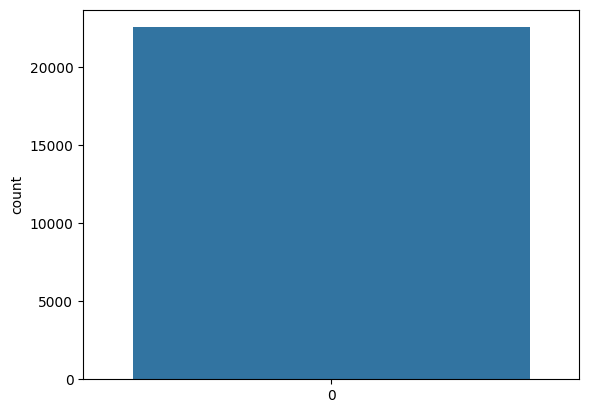

In [42]:
sns.countplot(test_df['attack'])

# Implementing Classification Models for Test Data

**Model Selection**
1. Random Forest
2. Decision Tree
3. Extreme Gradient Boosting (XGBoost)
4. Support Vector Machine (SVM)
5. Logistic Regression
6. K-Nearest Neighbors (KNN)
7. Convolutional Neural Networks (CNNs)
8. Recurrent Neural Networks (RNNs)
9. Artificial Neural Networks (ANNs) 
10. Multilayer Perceptron (MLP)

In [43]:
X_test_transformed = scaler.transform(X_test)

In [44]:
target_names=["attack","normal"]

**Random Forest** 

============================== Random Forest Classifier ==============================
Accuracy:  0.8292672107877928
Precision:  0.7250460687960688
Recall:  0.9724024302337555
F1-score:  0.8307015614691006
Random Forest Classification Report of NAD:
               precision    recall  f1-score   support

      attack       0.97      0.72      0.83     12833
      normal       0.73      0.97      0.83      9711

    accuracy                           0.83     22544
   macro avg       0.85      0.85      0.83     22544
weighted avg       0.87      0.83      0.83     22544



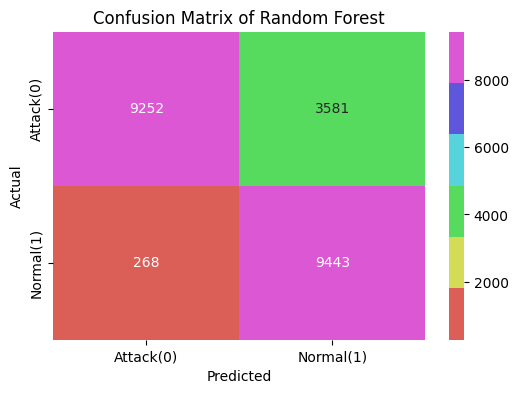


Confusion Matrix Parameters for Random Forest):
True Negatives (TN): 9252
False Positives (FP): 3581
False Negatives (FN): 268
True Positives (TP): 9443


In [45]:
print('============================== Random Forest Classifier ==============================')

# Predictions
rf_pred=rf.predict(X_transformed)
rf_test_pred=rf.predict(X_test_transformed)

# Classification report & confusion matrix
rf_report = classification_report(y_test, rf_test_pred,target_names=target_names)
rf_cm = confusion_matrix(y_test, rf_test_pred)

# Evaluation Metrics
print("Accuracy: ", accuracy_score(y_test, rf_test_pred))
print("Precision: ", precision_score(y_test, rf_test_pred))
print("Recall: ", recall_score(y_test, rf_test_pred))
print("F1-score: ", f1_score(y_test, rf_test_pred))
print("Random Forest Classification Report of NAD:\n", rf_report)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
cmap_husl = sns.hls_palette()
sns.heatmap(rf_cm, annot=True, fmt="d", cmap= cmap_husl, 
            xticklabels=["Attack(0)","Normal(1)"], 
            yticklabels=["Attack(0)","Normal(1)"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix of Random Forest")
plt.show()

# Print Confusion Matrix Components
tn, fp, fn, tp = confusion_matrix(y_test, rf_test_pred).ravel()
print('\nConfusion Matrix Parameters for Random Forest):')
print("True Negatives (TN):",tn)
print("False Positives (FP):",fp)
print("False Negatives (FN):",fn)
print("True Positives (TP):",tp)

**Decision-Tree Classifier**

============================== Decision-Tree Classifier ==============================
Accuracy:  0.8389371894960965
Precision:  0.7342425643396517
Recall:  0.9812583668005355
F1-score:  0.8399665035920489
Decision-Tree Classification Report of NAD:
               precision    recall  f1-score   support

      attack       0.98      0.73      0.84     12833
      normal       0.73      0.98      0.84      9711

    accuracy                           0.84     22544
   macro avg       0.86      0.86      0.84     22544
weighted avg       0.87      0.84      0.84     22544



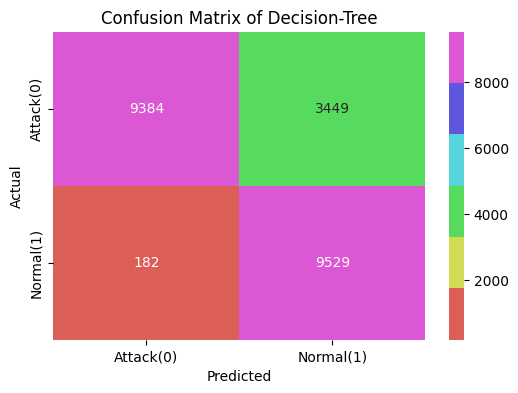


Confusion Matrix Parameters for Decision-Tree:
True Negatives (TN): 9384
False Positives (FP): 3449
False Negatives (FN): 182
True Positives (TP): 9529


In [46]:
print('============================== Decision-Tree Classifier ==============================')

# Predictions
dt_pred = dt.predict(X_test_transformed)
dt_test_pred=dt.predict(X_test_transformed)

# Classification report & confusion matrix
dt_report = classification_report(y_test, dt_test_pred,target_names=target_names)
dt_cm = confusion_matrix(y_test, dt_test_pred)

# Evaluation Metrics
print("Accuracy: ", accuracy_score(y_test,dt_test_pred))
print("Precision: ", precision_score(y_test,dt_test_pred))
print("Recall: ", recall_score(y_test, dt_test_pred))
print("F1-score: ", f1_score(y_test, dt_test_pred))
print("Decision-Tree Classification Report of NAD:\n", dt_report)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
cmap_husl = sns.hls_palette()
sns.heatmap(dt_cm, annot=True, fmt="d", cmap= cmap_husl, 
            xticklabels=["Attack(0)","Normal(1)"], 
            yticklabels=["Attack(0)","Normal(1)"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix of Decision-Tree")
plt.show()

# Print Confusion Matrix Components
tn, fp, fn, tp = confusion_matrix(y_test, dt_test_pred).ravel()
print('\nConfusion Matrix Parameters for Decision-Tree:')
print("True Negatives (TN):",tn)
print("False Positives (FP):",fp)
print("False Negatives (FN):",fn)
print("True Positives (TP):",tp)

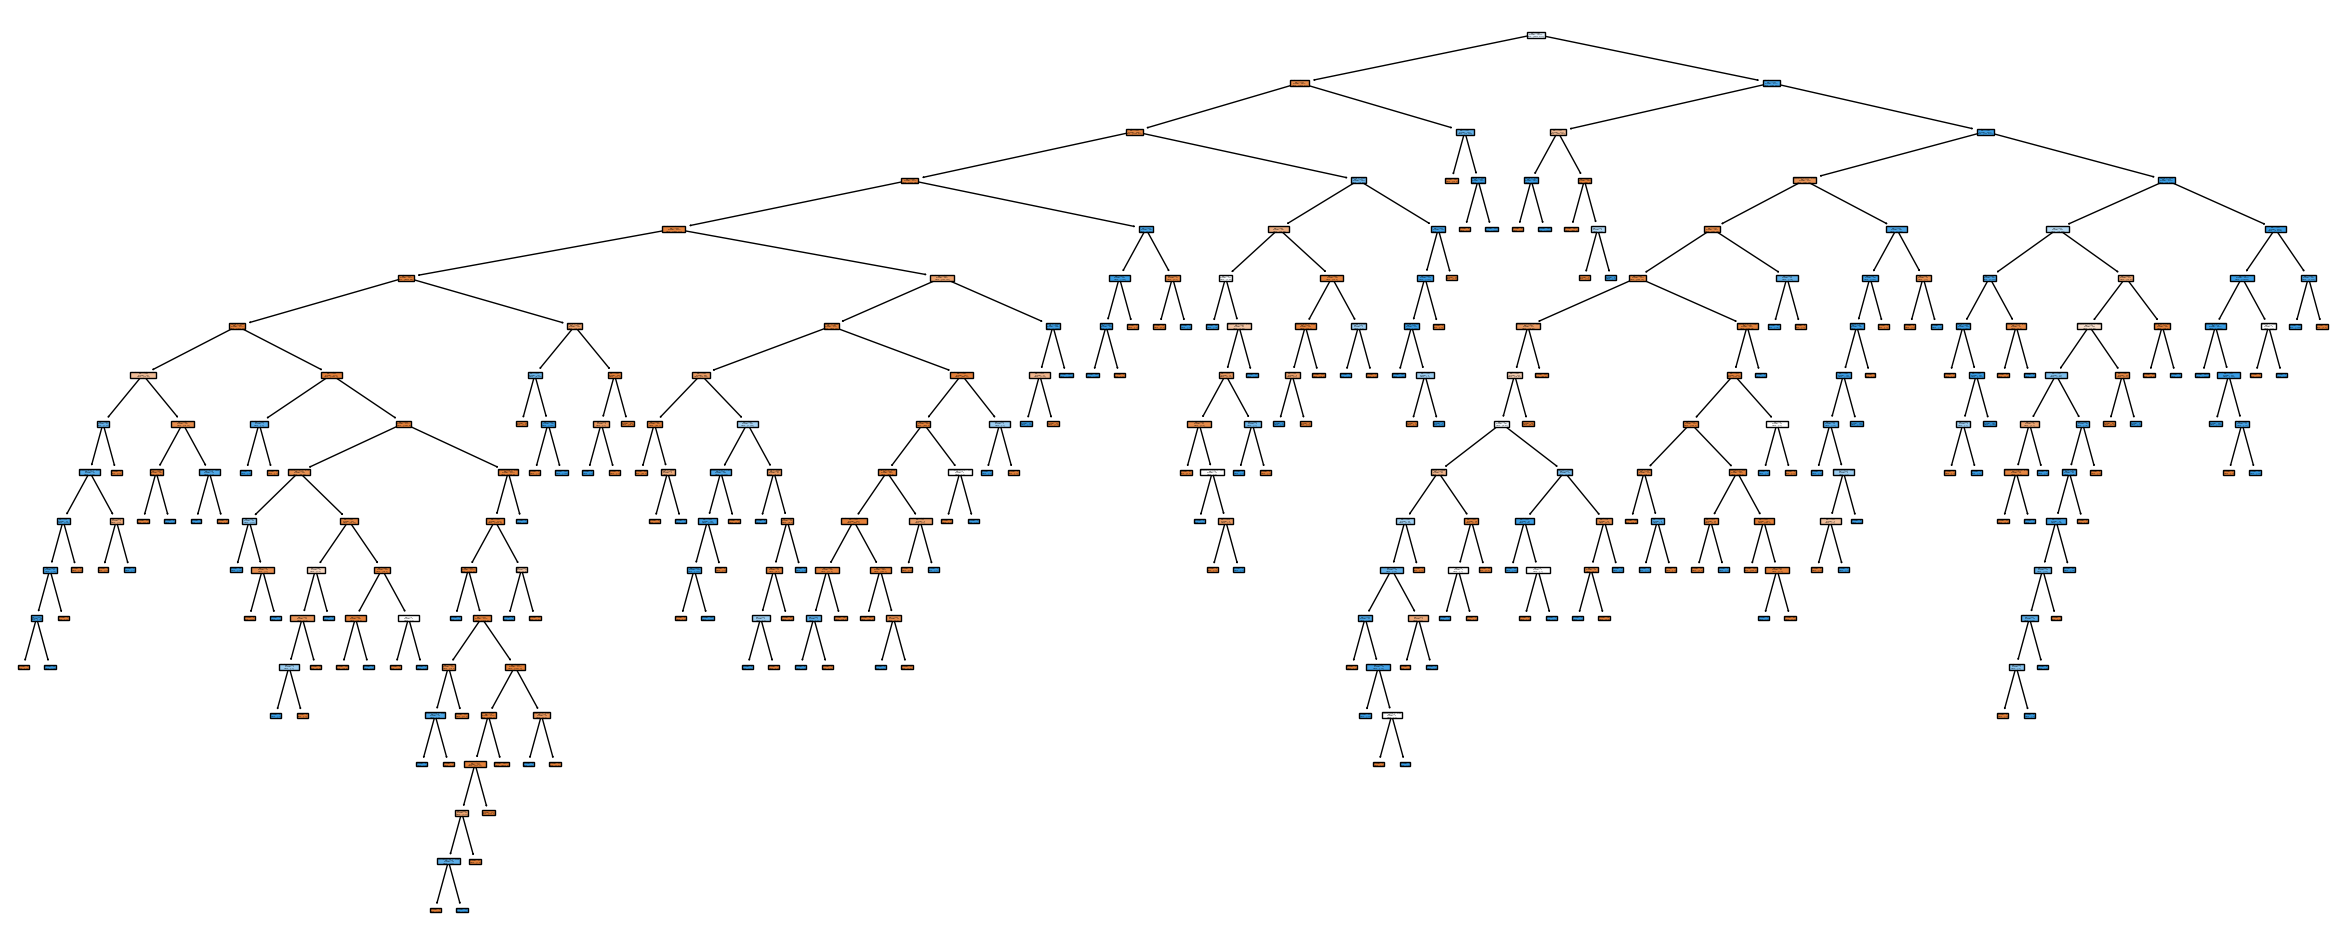

In [47]:
# Decision Tree Visualization
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(30, 12))
plot_tree(dt, filled=True, feature_names=X_test.columns)
plt.show()

**Extreme Gradient Boosting**

============================== XGBoost Classifier ==============================
Accuracy:  0.8561036195883606
Precision:  0.7607871602548593
Recall:  0.9713726701678509
F1-score:  0.8532790592492084
XGBoost Classification Report of NAD:
               precision    recall  f1-score   support

      attack       0.97      0.77      0.86     12833
      normal       0.76      0.97      0.85      9711

    accuracy                           0.86     22544
   macro avg       0.87      0.87      0.86     22544
weighted avg       0.88      0.86      0.86     22544



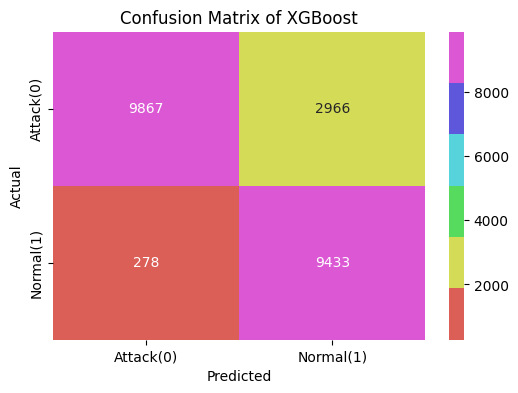


Confusion Matrix Parameters for XGBoost:
True Negatives (TN): 9867
False Positives (FP): 2966
False Negatives (FN): 278
True Positives (TP): 9433


In [48]:
print('============================== XGBoost Classifier ==============================')

# Predictions
xgb_pred=xgb.predict(X_transformed)
xgb_test_pred=xgb.predict(X_test_transformed)

# Classification report & confusion matrix
xgb_report = classification_report(y_test, xgb_test_pred,target_names=target_names)
xgb_cm = confusion_matrix(y_test, xgb_test_pred)

# Evaluation Metrics
print("Accuracy: ", accuracy_score(y_test,xgb_test_pred))
print("Precision: ", precision_score(y_test,xgb_test_pred))
print("Recall: ", recall_score(y_test, xgb_test_pred))
print("F1-score: ", f1_score(y_test, xgb_test_pred))
print("XGBoost Classification Report of NAD:\n", xgb_report)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
cmap_husl = sns.hls_palette()
sns.heatmap(xgb_cm, annot=True, fmt="d", cmap= cmap_husl, 
            xticklabels=["Attack(0)","Normal(1)"], 
            yticklabels=["Attack(0)","Normal(1)"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix of XGBoost")
plt.show()

# Print Confusion Matrix Components
tn, fp, fn, tp = confusion_matrix(y_test, xgb_test_pred).ravel()
print('\nConfusion Matrix Parameters for XGBoost:')
print("True Negatives (TN):", tn)
print("False Positives (FP):", fp)
print("False Negatives (FN):", fn)
print("True Positives (TP):", tp)

**Support Vector Machine (SVM)**

============================== Support Vector Machine (SVM) ==============================
Accuracy:  0.8576561391057488
Precision:  0.7656045751633986
Recall:  0.9649881577592421
F1-score:  0.8538107603298255
SVM Classification Report of NAD:
               precision    recall  f1-score   support

      attack       0.97      0.78      0.86     12833
      normal       0.77      0.96      0.85      9711

    accuracy                           0.86     22544
   macro avg       0.87      0.87      0.86     22544
weighted avg       0.88      0.86      0.86     22544



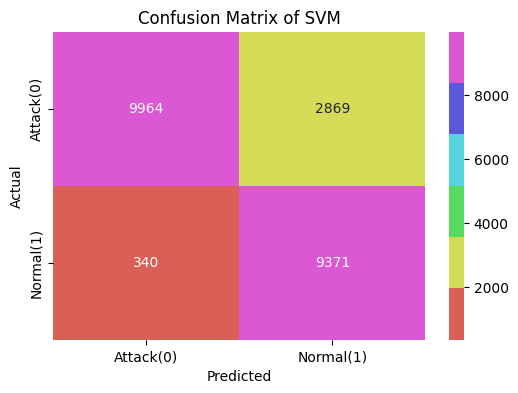


Confusion Matrix Parameters for Support Vector Machine (SVM):
True Negatives (TN): 9964
False Positives (FP): 2869
False Negatives (FN): 340
True Positives (TP): 9371


In [49]:
print('============================== Support Vector Machine (SVM) ==============================')

# Predictions
svm_pred=svm.predict(X_transformed)
svm_test_pred=svm.predict(X_test_transformed)

# Classification report & confusion matrix
svm_report = classification_report(y_test, svm_test_pred,target_names=target_names)
svm_cm = confusion_matrix(y_test, svm_test_pred)

# Evaluation Metrics
print("Accuracy: ", accuracy_score(y_test,svm_test_pred))
print("Precision: ", precision_score(y_test,svm_test_pred))
print("Recall: ", recall_score(y_test, svm_test_pred))
print("F1-score: ", f1_score(y_test, svm_test_pred))
print("SVM Classification Report of NAD:\n", svm_report)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
cmap_husl = sns.hls_palette()
sns.heatmap(svm_cm, annot=True, fmt="d", cmap= cmap_husl, 
            xticklabels=["Attack(0)","Normal(1)"], 
            yticklabels=["Attack(0)","Normal(1)"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix of SVM")
plt.show()

# Print Confusion Matrix Components
tn, fp, fn, tp = confusion_matrix(y_test, svm_test_pred).ravel()
print('\nConfusion Matrix Parameters for Support Vector Machine (SVM):')
print("True Negatives (TN):",tn)
print("False Positives (FP):",fp)
print("False Negatives (FN):",fn)
print("True Positives (TP):",tp)

**Logistic Regression**

============================== Logistic Regression ==============================
Accuracy:  0.8425745209368346
Precision:  0.7611016949152543
Recall:  0.924827515188961
F1-score:  0.8350146436706802
Logistic Regression Classification Report of NAD:
               precision    recall  f1-score   support

      attack       0.93      0.78      0.85     12833
      normal       0.76      0.92      0.84      9711

    accuracy                           0.84     22544
   macro avg       0.85      0.85      0.84     22544
weighted avg       0.86      0.84      0.84     22544



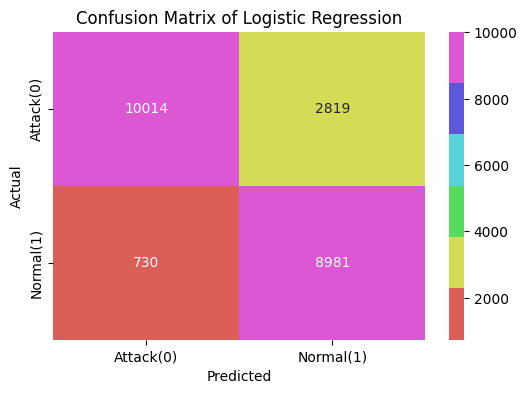


Confusion Matrix Parameters for Logistic Regression:
True Negatives (TN): 10014
False Positives (FP): 2819
False Negatives (FN): 730
True Positives (TP): 8981


In [50]:
print('============================== Logistic Regression ==============================')

# Predictions
lr_pred=lr.predict(X_transformed)
lr_test_pred=lr.predict(X_test_transformed)

# Classification report & confusion matrix
lr_report = classification_report(y_test, lr_test_pred,target_names=target_names)
lr_cm = confusion_matrix(y_test, lr_test_pred)

# Evaluation Metrics
print("Accuracy: ", accuracy_score(y_test,lr_test_pred))
print("Precision: ", precision_score(y_test,lr_test_pred))
print("Recall: ", recall_score(y_test, lr_test_pred))
print("F1-score: ", f1_score(y_test, lr_test_pred))
print("Logistic Regression Classification Report of NAD:\n", lr_report)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
cmap_husl = sns.hls_palette()
sns.heatmap(lr_cm, annot=True, fmt="d", cmap= cmap_husl, 
            xticklabels=["Attack(0)","Normal(1)"], 
            yticklabels=["Attack(0)","Normal(1)"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix of Logistic Regression")
plt.show()

# Print Confusion Matrix Components
tn, fp, fn, tp = confusion_matrix(y_test, lr_test_pred).ravel()
print('\nConfusion Matrix Parameters for Logistic Regression:')
print("True Negatives (TN):",tn)
print("False Positives (FP):",fp)
print("False Negatives (FN):",fn)
print("True Positives (TP):",tp)

**K-Nearest Neighbors (KNN)**

============================== K-Nearest Neighbors Classifier ==============================
Accuracy:  0.826472675656494
Precision:  0.7222009349375431
Recall:  0.9704458861085367
F1-score:  0.8281195079086116
KNN Classification Report of NAD:
               precision    recall  f1-score   support

      attack       0.97      0.72      0.82     12833
      normal       0.72      0.97      0.83      9711

    accuracy                           0.83     22544
   macro avg       0.85      0.84      0.83     22544
weighted avg       0.86      0.83      0.83     22544



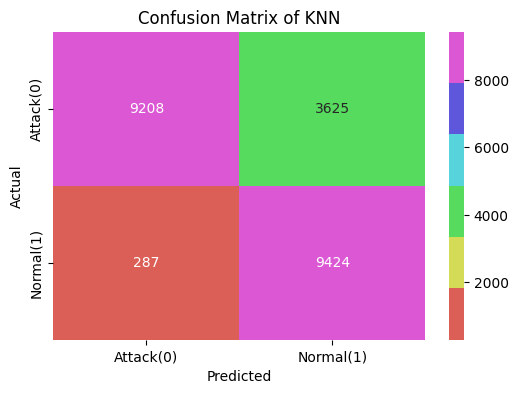


Confusion Matrix Parameters for K-Nearest Neighbors (KNN):
True Negatives (TN): 9208
False Positives (FP): 3625
False Negatives (FN): 287
True Positives (TP): 9424


In [51]:
print('============================== K-Nearest Neighbors Classifier ==============================')

# Predictions
knn_pred = knn.predict(X_transformed)
knn_test_pred=knn.predict(X_test_transformed)

# Classification report & confusion matrix
knn_report = classification_report(y_test, knn_test_pred,target_names=target_names)
knn_cm = confusion_matrix(y_test, knn_test_pred)

# Evaluation Metrics
print("Accuracy: ", accuracy_score(y_test,knn_test_pred))
print("Precision: ", precision_score(y_test,knn_test_pred))
print("Recall: ", recall_score(y_test, knn_test_pred))
print("F1-score: ", f1_score(y_test, knn_test_pred))
print("KNN Classification Report of NAD:\n", knn_report)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
cmap_husl = sns.hls_palette()
sns.heatmap(knn_cm, annot=True, fmt="d", cmap= cmap_husl, 
            xticklabels=["Attack(0)","Normal(1)"], 
            yticklabels=["Attack(0)","Normal(1)"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix of KNN")
plt.show()

# Print Confusion Matrix Components
tn, fp, fn, tp = confusion_matrix(y_test, knn_test_pred).ravel()
print('\nConfusion Matrix Parameters for K-Nearest Neighbors (KNN):')
print("True Negatives (TN):",tn)
print("False Positives (FP):",fp)
print("False Negatives (FN):",fn)
print("True Positives (TP):",tp)

**Convolutional Neural Networks (CNNs)**


============================== Convolutional Neural Network (CNN) ==============================
705/705 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy:  0.84958303761533
Precision:  0.7518329614281161
Recall:  0.9714756461744414
F1-score:  0.8476571274540635
CNN Classification Report of NAD:
               precision    recall  f1-score   support

      attack       0.97      0.76      0.85     12833
      normal       0.75      0.97      0.85      9711

    accuracy                           0.85     22544
   macro avg       0.86      0.86      0.85     22544
weighted avg       0.88      0.85      0.85     22544



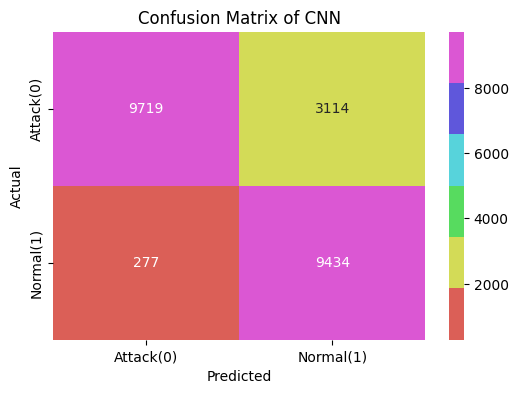


Confusion Matrix Parameters for Convolutional Neural Network (CNN):
True Negatives (TN): 9719
False Positives (FP): 3114
False Negatives (FN): 277
True Positives (TP): 9434


In [52]:
print('\n============================== Convolutional Neural Network (CNN) ==============================')

# Transform and reshape test data
X_test_transformed = scaler.transform(X_test)
X_test_cnn = np.expand_dims(X_test_transformed, axis=-1)

# Predictions
cnn_test_pred = (cnn_model.predict(X_test_cnn) > 0.5).astype(int)

# Classification report & confusion matrix
cnn_report = classification_report(y_test, cnn_test_pred, target_names=target_names)
cnn_cm = confusion_matrix(y_test, cnn_test_pred)

# Evaluation Metrics
print("Accuracy: ", accuracy_score(y_test,cnn_test_pred))
print("Precision: ", precision_score(y_test,cnn_test_pred))
print("Recall: ", recall_score(y_test, cnn_test_pred))
print("F1-score: ", f1_score(y_test, cnn_test_pred))
print("CNN Classification Report of NAD:\n", cnn_report)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
cmap_husl = sns.hls_palette()
sns.heatmap(cnn_cm, annot=True, fmt="d", cmap= cmap_husl, 
            xticklabels=["Attack(0)","Normal(1)"], 
            yticklabels=["Attack(0)","Normal(1)"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix of CNN")
plt.show()

# Print Confusion Matrix Components
tn, fp, fn, tp = confusion_matrix(y_test, cnn_test_pred).ravel()
print('\nConfusion Matrix Parameters for Convolutional Neural Network (CNN):')
print("True Negatives (TN):",tn)
print("False Positives (FP):",fp)
print("False Negatives (FN):",fn)
print("True Positives (TP):",tp)

**Recurrent Neural Networks (RNNs)**


============================== Recurrent Neural Network (RNN) ==============================
705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy:  0.8758427963094393
Precision:  0.7915471570777797
Recall:  0.9662238698383276
F1-score:  0.8702063528866218
CNN Classification Report of NAD:
               precision    recall  f1-score   support

      attack       0.97      0.81      0.88     12833
      normal       0.79      0.97      0.87      9711

    accuracy                           0.88     22544
   macro avg       0.88      0.89      0.88     22544
weighted avg       0.89      0.88      0.88     22544



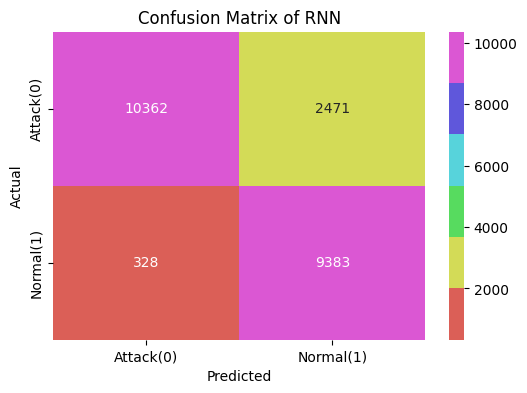


Confusion Matrix Parameters for Recurrent Neural Network (RNN):
True Negatives (TN): 10362
False Positives (FP): 2471
False Negatives (FN): 328
True Positives (TP): 9383


In [53]:
print('\n============================== Recurrent Neural Network (RNN) ==============================')

# Reshape test data
X_test_rnn = X_test_transformed.reshape(X_test_transformed.shape[0], 1, X_test_transformed.shape[1])

# Predictions
rnn_test_pred = (rnn_model.predict(X_test_rnn) > 0.5).astype(int)

# Classification report & confusion matrix
rnn_report = classification_report(y_test, rnn_test_pred, target_names=target_names)
rnn_cm = confusion_matrix(y_test, rnn_test_pred)

# Evaluation Metrics
print("Accuracy: ", accuracy_score(y_test,rnn_test_pred))
print("Precision: ", precision_score(y_test,rnn_test_pred))
print("Recall: ", recall_score(y_test, rnn_test_pred))
print("F1-score: ", f1_score(y_test, rnn_test_pred))
print("CNN Classification Report of NAD:\n", rnn_report)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
cmap_husl = sns.hls_palette()
sns.heatmap(rnn_cm, annot=True, fmt="d", cmap= cmap_husl, 
            xticklabels=["Attack(0)","Normal(1)"], 
            yticklabels=["Attack(0)","Normal(1)"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix of RNN")
plt.show()

# Print Confusion Matrix Components
tn, fp, fn, tp = confusion_matrix(y_test, rnn_test_pred).ravel()
print('\nConfusion Matrix Parameters for Recurrent Neural Network (RNN):')
print("True Negatives (TN):",tn)
print("False Positives (FP):",fp)
print("False Negatives (FN):",fn)
print("True Positives (TP):",tp)

**Artificial Neural Networks (ANNs)**


============================== Artificial Neural Network (ANN) ==============================
705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy:  0.8814318665720369
Precision:  0.7993365090166723
Recall:  0.9676655339305942
F1-score:  0.8754832999487586
CNN Classification Report of NAD:
               precision    recall  f1-score   support

      attack       0.97      0.82      0.89     12833
      normal       0.80      0.97      0.88      9711

    accuracy                           0.88     22544
   macro avg       0.89      0.89      0.88     22544
weighted avg       0.90      0.88      0.88     22544



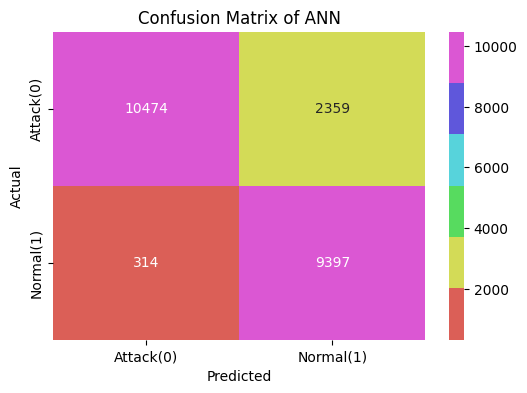


Confusion Matrix Parameters for Artificial Neural Network (ANN):
True Negatives (TN): 10474
False Positives (FP): 2359
False Negatives (FN): 314
True Positives (TP): 9397


In [54]:
print('\n============================== Artificial Neural Network (ANN) ==============================')

# Predictions
ann_test_pred = (ann_model.predict(X_test_transformed) > 0.5).astype(int)

# Classification report & confusion matrix
ann_report = classification_report(y_test, ann_test_pred, target_names=target_names)
ann_cm = confusion_matrix(y_test, ann_test_pred)

# Evaluation Metrics
print("Accuracy: ", accuracy_score(y_test,ann_test_pred))
print("Precision: ", precision_score(y_test,ann_test_pred))
print("Recall: ", recall_score(y_test, ann_test_pred))
print("F1-score: ", f1_score(y_test, ann_test_pred))
print("CNN Classification Report of NAD:\n", ann_report)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
cmap_husl = sns.hls_palette()
sns.heatmap(ann_cm, annot=True, fmt="d", cmap= cmap_husl, 
            xticklabels=["Attack(0)","Normal(1)"], 
            yticklabels=["Attack(0)","Normal(1)"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix of ANN")
plt.show()

# Print Confusion Matrix Components
tn, fp, fn, tp = confusion_matrix(y_test, ann_test_pred).ravel()
print('\nConfusion Matrix Parameters for Artificial Neural Network (ANN):')
print("True Negatives (TN):",tn)
print("False Positives (FP):",fp)
print("False Negatives (FN):",fn)
print("True Positives (TP):",tp)

**Multilayer Perceptron (MLP)**


============================== Multilayer Perceptron (MLP) ==============================
705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy:  0.8730926188786373
Precision:  0.7872358269037236
Recall:  0.9666357738646896
F1-score:  0.8677605731453664
MPL Classification Report of NAD:
               precision    recall  f1-score   support

      attack       0.97      0.80      0.88     12833
      normal       0.79      0.97      0.87      9711

    accuracy                           0.87     22544
   macro avg       0.88      0.88      0.87     22544
weighted avg       0.89      0.87      0.87     22544



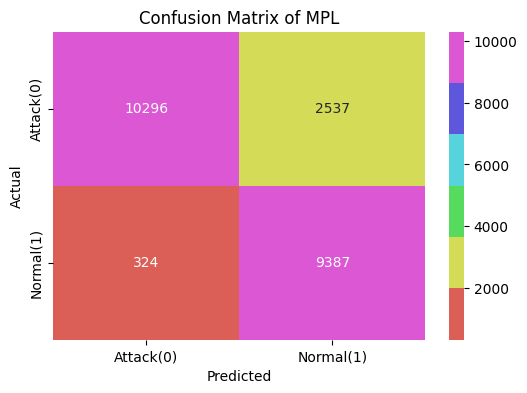


Confusion Matrix Parameters for Multilayer Perceptron (MLP):
True Negatives (TN): 10296
False Positives (FP): 2537
False Negatives (FN): 324
True Positives (TP): 9387


In [55]:
print('\n============================== Multilayer Perceptron (MLP) ==============================')

# Predictions
mlp_test_pred = (mlp_model.predict(X_test_transformed) > 0.5).astype(int)

# Classification report & confusion matrix
mlp_report = classification_report(y_test, mlp_test_pred, target_names=target_names)
mlp_cm = confusion_matrix(y_test, mlp_test_pred)

# Evaluation Metrics
print("Accuracy: ", accuracy_score(y_test,mlp_test_pred))
print("Precision: ", precision_score(y_test,mlp_test_pred))
print("Recall: ", recall_score(y_test, mlp_test_pred))
print("F1-score: ", f1_score(y_test, mlp_test_pred))
print("MPL Classification Report of NAD:\n", mlp_report)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
cmap_husl = sns.hls_palette()
sns.heatmap(mlp_cm, annot=True, fmt="d", cmap= cmap_husl, 
            xticklabels=["Attack(0)","Normal(1)"], 
            yticklabels=["Attack(0)","Normal(1)"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix of MPL")
plt.show()

# Print Confusion Matrix Components
tn, fp, fn, tp = confusion_matrix(y_test, mlp_test_pred).ravel()
print('\nConfusion Matrix Parameters for Multilayer Perceptron (MLP):')
print("True Negatives (TN):",tn)
print("False Positives (FP):",fp)
print("False Negatives (FN):",fn)
print("True Positives (TP):",tp)

# Receiver Operating Characteristic (ROC) Curve for Anomaly Detection

705/705 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


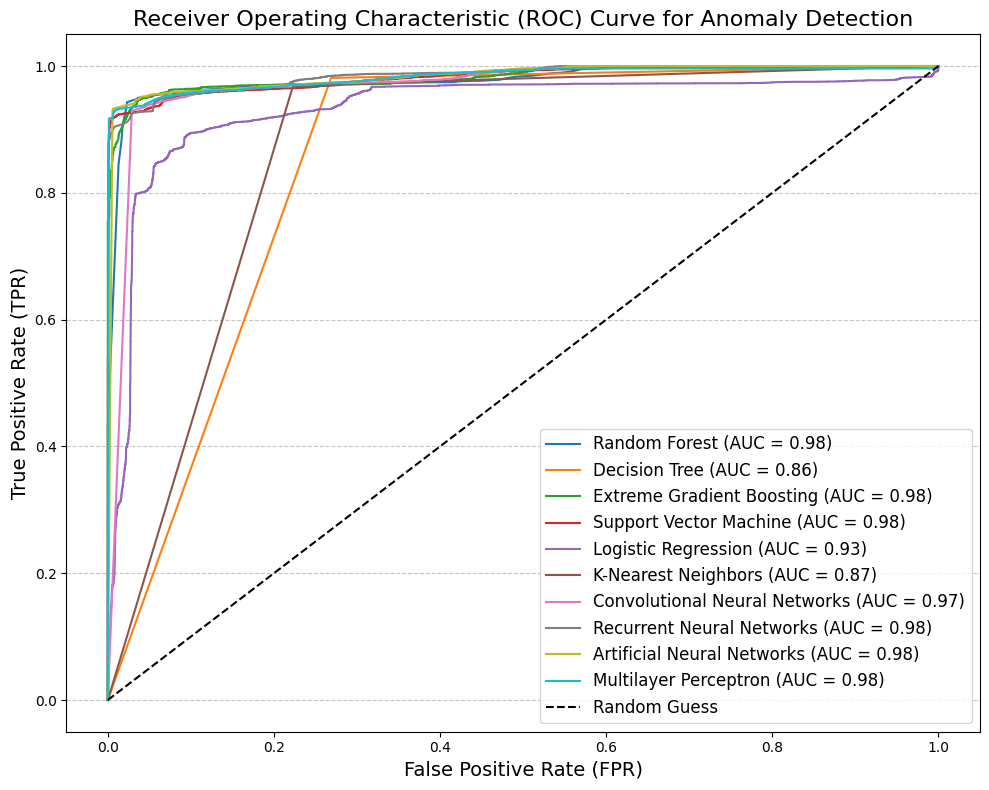

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Function to plot ROC curves for both ML and DL models
def plot_roc_curve(y_true, model_scores_dict):
    plt.figure(figsize=(10, 8))

    for model_name, scores in model_scores_dict.items():
        fpr, tpr, _ = roc_curve(y_true, scores)
        auc = roc_auc_score(y_true, scores)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Guess')
    plt.title('Receiver Operating Characteristic (ROC) Curve for Anomaly Detection', fontsize=16)
    plt.xlabel('False Positive Rate (FPR)', fontsize=14)
    plt.ylabel('True Positive Rate (TPR)', fontsize=14)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

# Example usage
model_scores_dict = {
    'Random Forest': rf.predict_proba(X_test_transformed)[:, 1],
    'Decision Tree': dt.predict_proba(X_test_transformed)[:, 1],
    'Extreme Gradient Boosting': xgb.predict_proba(X_test_transformed)[:, 1],
    'Support Vector Machine': svm.decision_function(X_test_transformed),
    'Logistic Regression': lr.predict_proba(X_test_transformed)[:, 1],
    'K-Nearest Neighbors': knn.predict_proba(X_test_transformed)[:, 1],
    'Convolutional Neural Networks': cnn_model.predict(X_test_cnn).ravel(),
    'Recurrent Neural Networks': rnn_model.predict(X_test_rnn).ravel(),
    'Artificial Neural Networks': ann_model.predict(X_test_transformed).ravel(),
    'Multilayer Perceptron': mlp_model.predict(X_test_transformed).ravel()
}

# Plot ROC curve
plot_roc_curve(y_test, model_scores_dict)

# Training and Validation Accuracy

In [57]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_transformed.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [58]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [59]:
history = model.fit(X_transformed, y, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9685 - loss: 0.0850 - val_accuracy: 0.9960 - val_loss: 0.0110
Epoch 2/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9944 - loss: 0.0139 - val_accuracy: 0.9971 - val_loss: 0.0085
Epoch 3/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9963 - loss: 0.0101 - val_accuracy: 0.9969 - val_loss: 0.0081
Epoch 4/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9962 - loss: 0.0106 - val_accuracy: 0.9976 - val_loss: 0.0076
Epoch 5/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9969 - loss: 0.0078 - val_accuracy: 0.9978 - val_loss: 0.0065
Epoch 6/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9972 - loss: 0.0070 - val_accuracy: 0.9982 - val_loss: 0.0072
Epoch 7/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9976 - loss: 0.0076 - val_accuracy: 0.9983 - val_loss: 0.0062
Epoch 8/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9980 - loss: 0.0058 - 

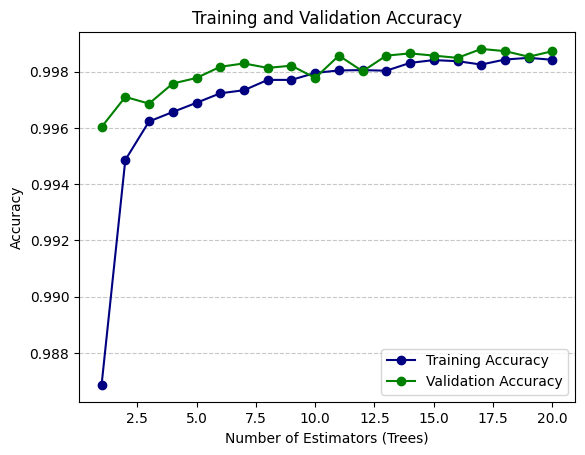

In [60]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_accuracy) + 1)

# Plot Training and Validation Accuracy
#plt.figure(figsize=(10, 6))
plt.plot(epochs, training_accuracy, 'navy', label='Training Accuracy', marker='o')
plt.plot(epochs, validation_accuracy, 'green',label='Validation Accuracy', marker='o')
plt.xlabel('Number of Estimators (Trees)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.show()

In [61]:
test_loss, test_acc = model.evaluate(X_test_transformed, y_test)
print(f'Test accuracy: {test_acc}')

705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8830 - loss: 1.4599
Test accuracy: 0.8796575665473938


In [62]:
predictions = model.predict(X_test_transformed)
predictions = (predictions > 0.5)

705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [63]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 64)                  │           2,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,829 (54.02 KB)

 Trainable params: 4,609 (18.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,220 (36.02 KB)

In [64]:
y_pred = (predictions > 0.5).astype(int)

In [65]:
report = classification_report(y_test, y_pred)

In [66]:
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.81      0.88     12833
           1       0.80      0.97      0.87      9711

    accuracy                           0.88     22544
   macro avg       0.88      0.89      0.88     22544
weighted avg       0.90      0.88      0.88     22544



# **Visualization of Anomaly Score Distributions**

Use a histogram or Kernel Density Estimate (KDE) plot to visualize the distribution of anomaly scores for Normal and Attack classes.

705/705 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


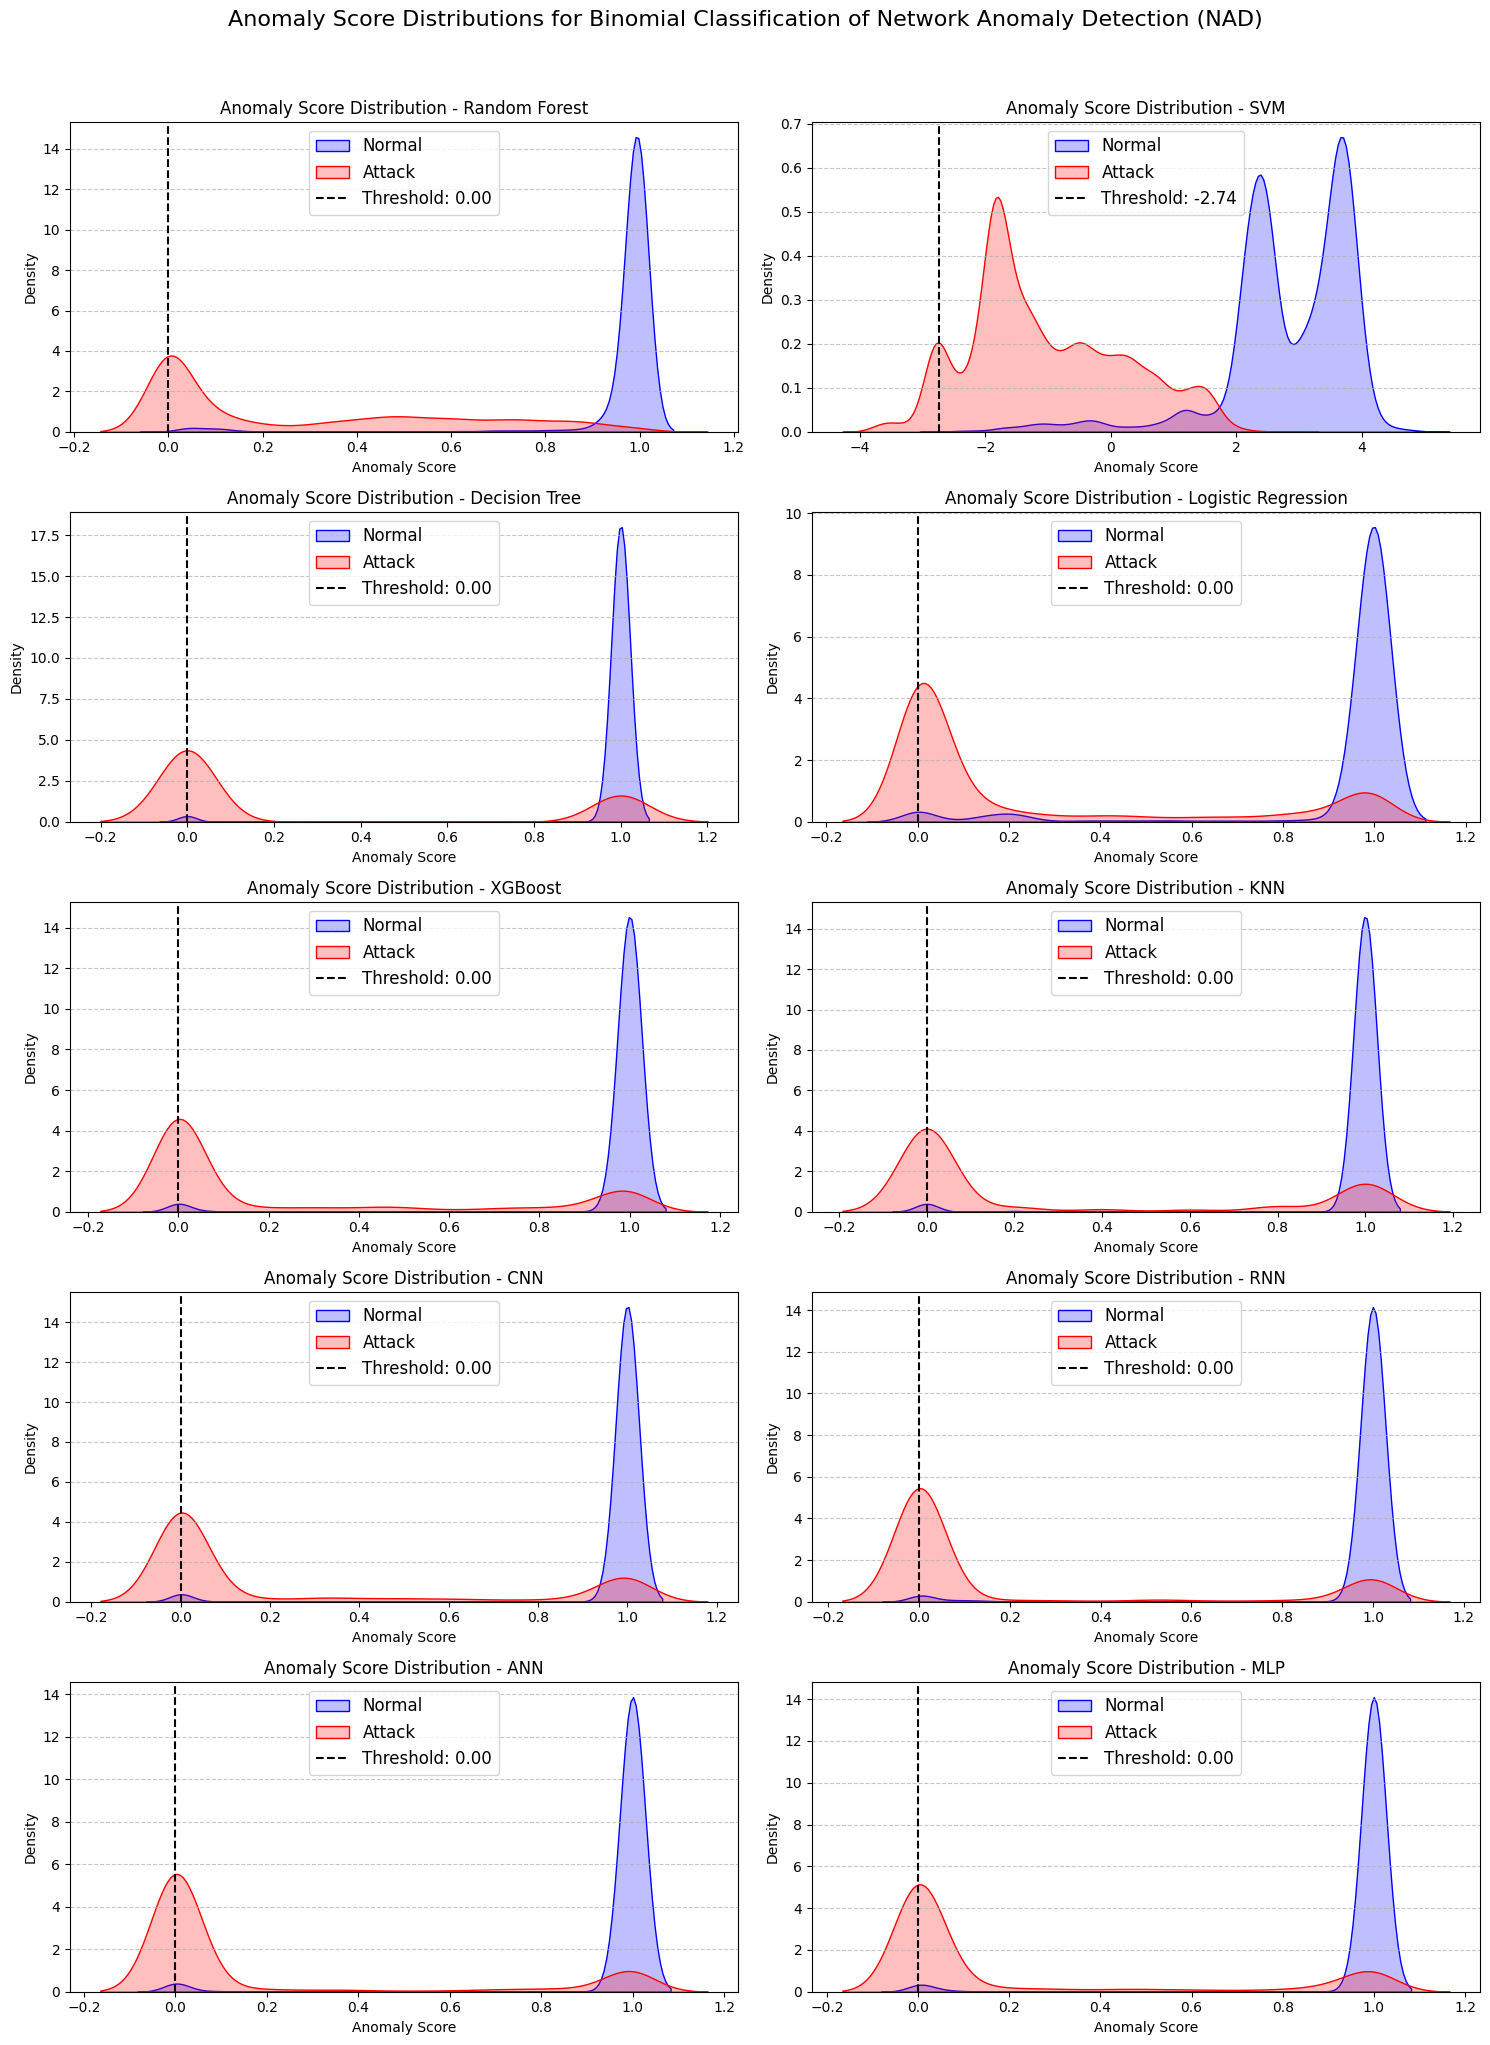

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot anomaly score distribution
def plot_anomaly_score_distribution(ax, y_true, scores, model_name):
    sns.kdeplot(scores[y_true == 1], label='Normal', color='blue', fill=True, ax=ax)
    sns.kdeplot(scores[y_true == 0], label='Attack', color='red', fill=True, ax=ax)

    threshold = np.percentile(scores, 5)
    ax.axvline(threshold, color='black', linestyle='--', label=f'Threshold: {threshold:.2f}')
    
    ax.set_title(f'Anomaly Score Distribution - {model_name}', fontsize=12)
    ax.set_xlabel('Anomaly Score', fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.legend(loc="upper center", fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Example usage
model_scores_dict = {
    'Random Forest': rf.predict_proba(X_test_transformed)[:, 1],
    'SVM': svm.decision_function(X_test_transformed),
    'Decision Tree': dt.predict_proba(X_test_transformed)[:, 1],
    'Logistic Regression': lr.predict_proba(X_test_transformed)[:, 1],
    'XGBoost': xgb.predict_proba(X_test_transformed)[:, 1],
    'KNN': knn.predict_proba(X_test_transformed)[:, 1],
    'CNN': cnn_model.predict(X_test_cnn).ravel(),
    'RNN': rnn_model.predict(X_test_rnn).ravel(),
    'ANN': ann_model.predict(X_test_transformed).ravel(),
    'MLP': mlp_model.predict(X_test_transformed).ravel()
}

# Create subplot grid based on number of models
n_models = len(model_scores_dict)
n_rows = (n_models + 1) // 2  # Adjust for 5x2 layout

fig, axes = plt.subplots(n_rows, 2, figsize=(15, n_rows*4))
axes = axes.flatten()

plt.suptitle('Anomaly Score Distributions for Binomial Classification of Network Anomaly Detection (NAD)'
             , fontsize=16, y=1.02)

# Plot each model's anomaly score distribution
for i, (model_name, scores) in enumerate(model_scores_dict.items()):
    plot_anomaly_score_distribution(axes[i], y_test, scores, model_name)

# Hide extra axes if not filled
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

In [68]:
import numpy as np

# Check unique values in the target variable
unique_classes = np.unique(y)
print("Unique Classes in Target Variable:", unique_classes)

Unique Classes in Target Variable: [0 1]


In [69]:
from collections import Counter

# Count the number of instances for each class
class_distribution = Counter(y)
print("Class Distribution:", class_distribution)

Class Distribution: Counter({1: 67343, 0: 58630})


# Model Summary
* Confusion Matrix Parameters
* Performance Summary of All Ten Models
* Model Performance Comparison for Anomaly Detection
* Accuracy of Different ML Models

Confusion Matrix Parameters for All Models:
                                  Model  True Negatives (TN)  \
0                         Random Forest                 9252   
1                         Decision Tree                 9384   
2   Extreme Gradient Boosting (XGBoost)                 9867   
3          Support Vector Machine (SVM)                 9964   
4                   Logistic Regression                10014   
5             K-Nearest Neighbors (KNN)                 9208   
6  Convolutional Neural Networks (CNNs)                 9719   
7      Recurrent Neural Networks (RNNs)                10362   
8     Artificial Neural Networks (ANNs)                10474   
9           Multilayer Perceptron (MLP)                10296   

   False Positives (FP)  False Negatives (FN)  True Positives (TP)  
0                  3581                   268                 9443  
1                  3449                   182                 9529  
2                  2966                   27

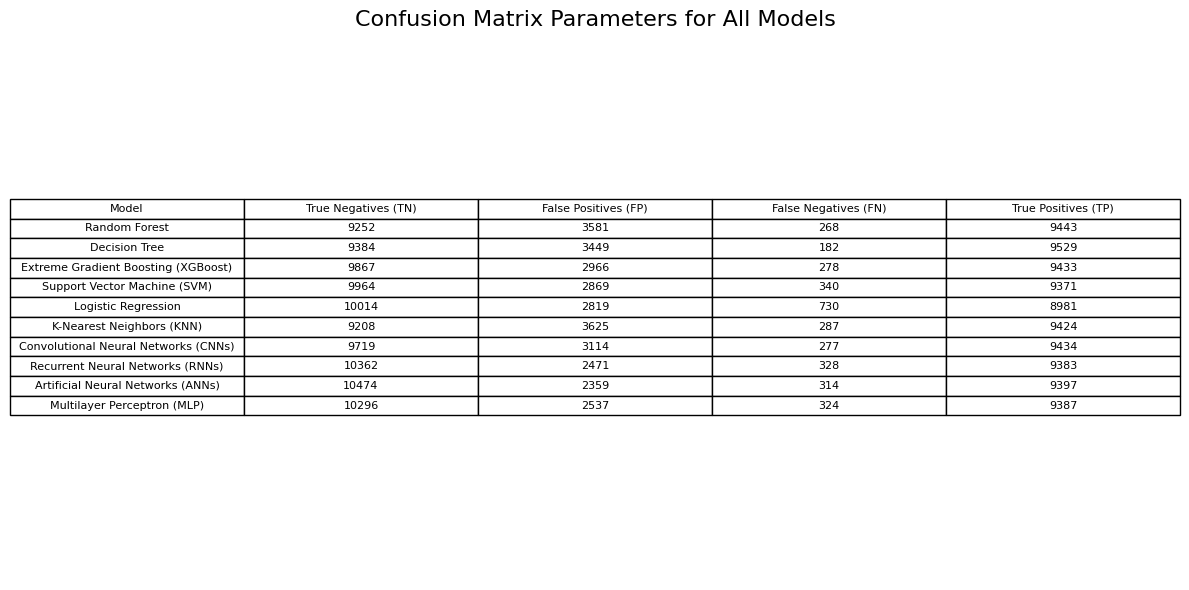

In [70]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def get_confusion_matrix_params(y_true, y_pred, model_name):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {
        'Model': model_name,
        'True Negatives (TN)': tn,
        'False Positives (FP)': fp,
        'False Negatives (FN)': fn,
        'True Positives (TP)': tp
    }

# Unified predictions dictionary for ML and DL
all_predictions = {
    'Random Forest': rf_test_pred,
    'Decision Tree': dt_test_pred,
    'Extreme Gradient Boosting (XGBoost)': xgb_test_pred,
    'Support Vector Machine (SVM)': svm_test_pred,
    'Logistic Regression': lr_test_pred,
    'K-Nearest Neighbors (KNN)':  knn_test_pred, 
    'Convolutional Neural Networks (CNNs)': cnn_test_pred,
    'Recurrent Neural Networks (RNNs)': rnn_test_pred,
    'Artificial Neural Networks (ANNs)': ann_test_pred,
    'Multilayer Perceptron (MLP)': mlp_test_pred

}

# Build the table
confusion_matrix_list = [
    get_confusion_matrix_params(y_test, y_pred, model_name)
    for model_name, y_pred in all_predictions.items()
]

confusion_matrix_df = pd.DataFrame(confusion_matrix_list)
print("Confusion Matrix Parameters for All Models:")
print(confusion_matrix_df)

# Plot the table
plt.figure(figsize=(12, 6))
plt.axis('off')
table = plt.table(
    cellText=confusion_matrix_df.values,
    colLabels=confusion_matrix_df.columns,
    loc='center',
    cellLoc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(8)
plt.title("Confusion Matrix Parameters for All Models", fontsize=16)
plt.tight_layout()
plt.show()


Performance Metrics for All Models (in %):
                                  Model  Accuracy (%)  Precision (%)  \
0                         Random Forest         82.93          86.55   
1                         Decision Tree         83.89          87.47   
2   Extreme Gradient Boosting (XGBoost)         85.61          88.14   
3          Support Vector Machine (SVM)         85.77          88.02   
4                   Logistic Regression         84.26          85.84   
5             K-Nearest Neighbors (KNN)         82.65          86.31   
6  Convolutional Neural Networks (CNNs)         84.96          87.73   
7      Recurrent Neural Networks (RNNs)         87.58          89.27   
8     Artificial Neural Networks (ANNs)         88.14          89.70   
9           Multilayer Perceptron (MLP)         87.31          89.10   

   Recall (%)  F1-Score (%)  
0       82.93         82.91  
1       83.89         83.88  
2       85.61         85.64  
3       85.77         85.81  
4       84.26

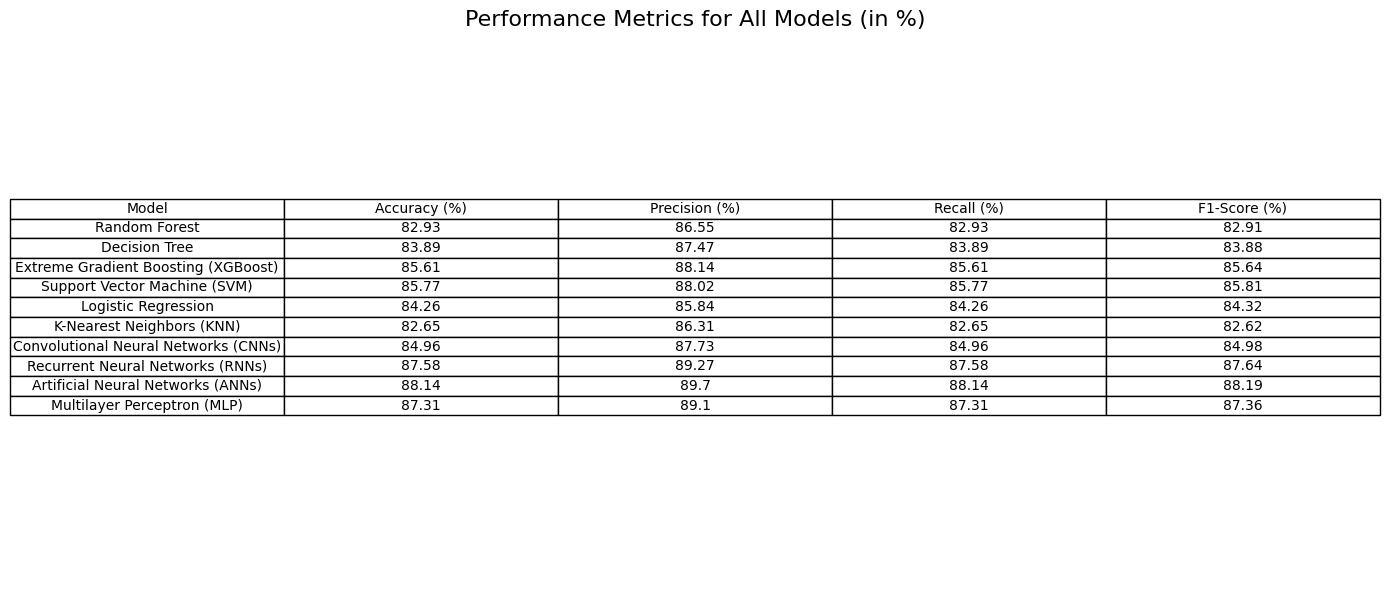

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(y_true, y_pred, model_name):
    return {
        'Model': model_name,
        'Accuracy (%)': round(accuracy_score(y_true, y_pred) * 100, 2),
        'Precision (%)': round(precision_score(y_true, y_pred, average='weighted') * 100, 2),
        'Recall (%)': round(recall_score(y_true, y_pred, average='weighted') * 100, 2),
        'F1-Score (%)': round(f1_score(y_true, y_pred, average='weighted') * 100, 2)
    }

metrics_list = [
    calculate_metrics(y_test, y_pred, model_name)
    for model_name, y_pred in all_predictions.items()
]

metrics_df = pd.DataFrame(metrics_list)
print("\nPerformance Metrics for All Models (in %):")
print(metrics_df)

# Plot the table
plt.figure(figsize=(14, 6))
plt.axis('off')
table = plt.table(
    cellText=metrics_df.values,
    colLabels=metrics_df.columns,
    loc='center',
    cellLoc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
plt.title("Performance Metrics for All Models (in %)", fontsize=16)
plt.tight_layout()
plt.show()


<Figure size 1400x1200 with 0 Axes>

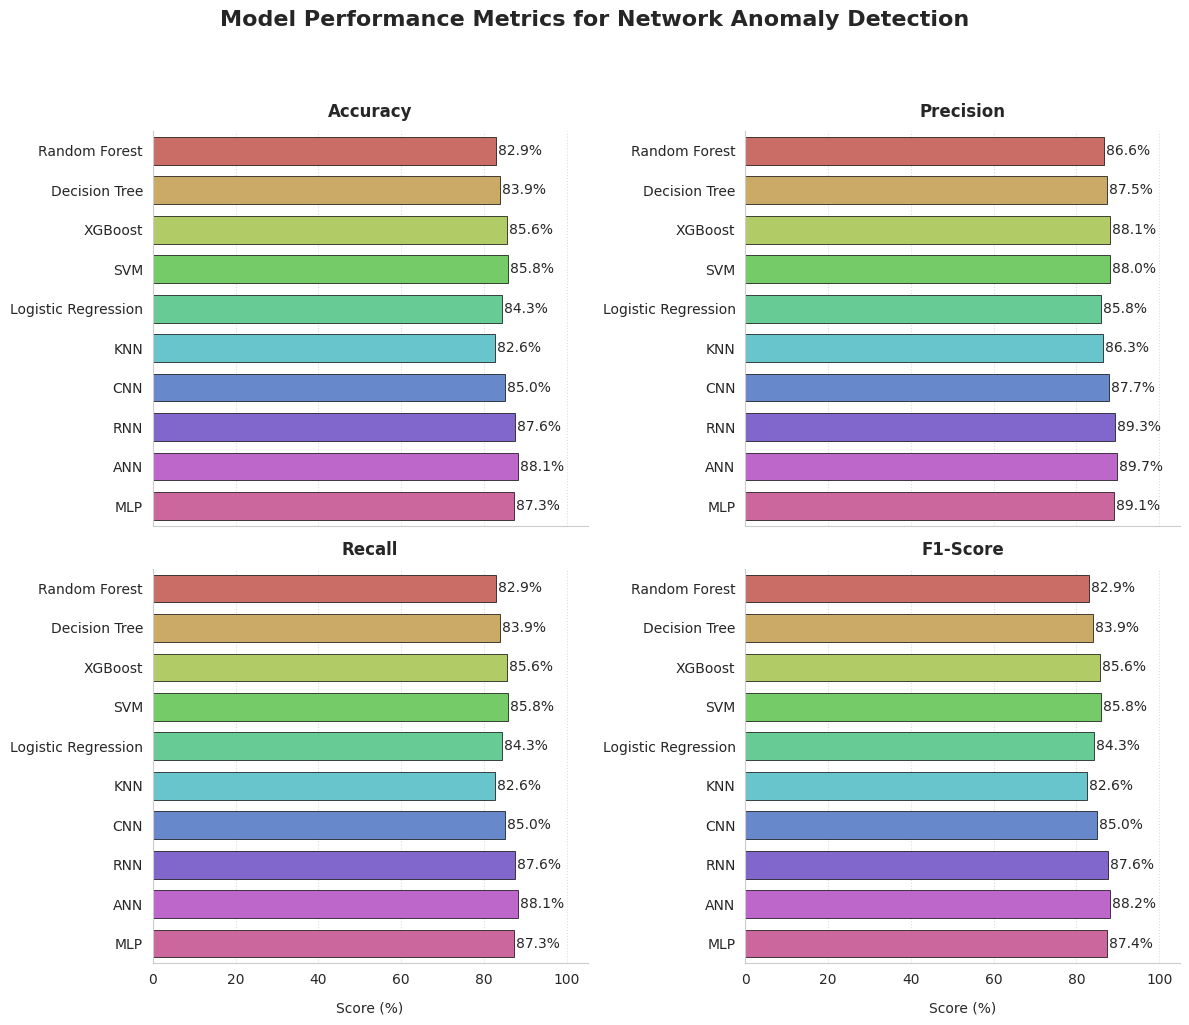

In [72]:
import seaborn as sns

def evaluate_model(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred) * 100,
        'Precision': precision_score(y_true, y_pred, average='weighted') * 100,
        'Recall': recall_score(y_true, y_pred, average='weighted') * 100,
        'F1-Score': f1_score(y_true, y_pred, average='weighted') * 100
    }

# Unified predictions dictionary for ML and DL
all_predictions = {
    'Random Forest': rf_test_pred,
    'Decision Tree': dt_test_pred,
    'XGBoost': xgb_test_pred,
    'SVM': svm_test_pred,
    'Logistic Regression': lr_test_pred,
    'KNN': knn_test_pred,
    'CNN': cnn_test_pred,
    'RNN': rnn_test_pred,
    'ANN': ann_test_pred,
    'MLP': mlp_test_pred
}

# Create melted DataFrame for plotting
metrics_data = []
for model_name, pred in all_predictions.items():
    metrics = evaluate_model(y_test, pred)
    for metric_name, score in metrics.items():
        metrics_data.append({
            'Model': model_name,
            'Metric': metric_name,
            'Score': score
        })
metrics_plot_df = pd.DataFrame(metrics_data)

# Create the faceted bar plot
plt.figure(figsize=(14, 12))
sns.set_style("whitegrid", {'grid.linestyle': ':'})
palette = sns.color_palette("hls", len(all_predictions))

g = sns.FacetGrid(
    metrics_plot_df,
    col='Metric',
    col_wrap=2,
    height=5,
    aspect=1.2,
    sharey=False
)

g.map_dataframe(
    sns.barplot,
    x='Score',
    y='Model',
    palette=palette,
    order=list(all_predictions.keys()),
    width=0.7,
    edgecolor='black',
    linewidth=0.5
)

for ax, metric in zip(g.axes.flat, metrics_plot_df['Metric'].unique()):
    for p in ax.patches:
        width = p.get_width()
        ax.annotate(
            f'{width:.1f}%',
            (width + 0.5, p.get_y() + p.get_height()/2),
            ha='left',
            va='center',
            fontsize=10
        )
    ax.set_xlim(0, 105)
    ax.set_title(f"{metric}", fontweight='bold', pad=10)
    ax.set_xlabel('Score (%)', labelpad=10)
    ax.set_ylabel('')
    ax.grid(True, axis='x', linestyle=':', alpha=0.7)

g.fig.suptitle('Model Performance Metrics for Network Anomaly Detection\n', y=1.02, fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

705/705 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


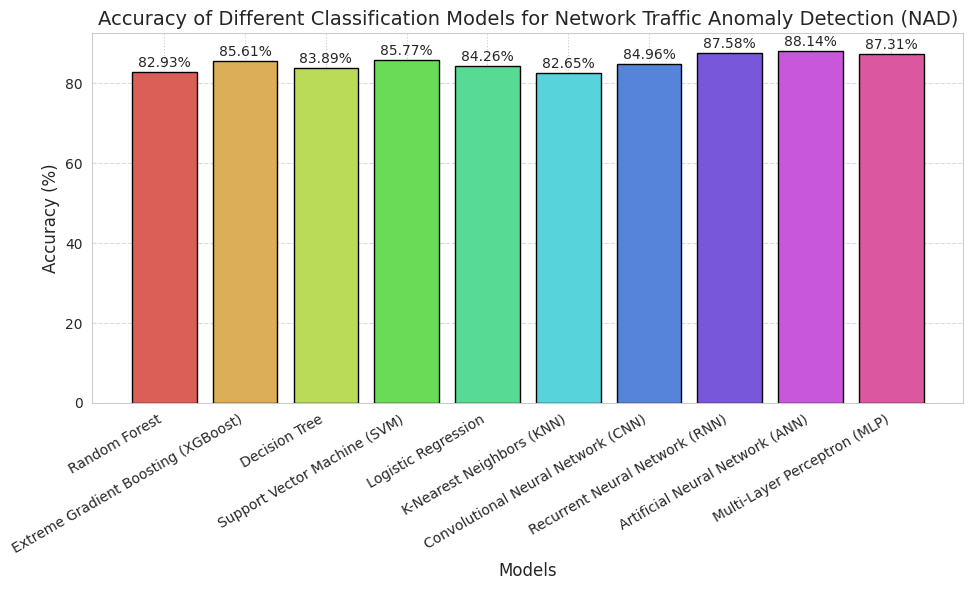

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

# --- Accuracy function ---
def calculate_accuracy(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred) * 100
    return {'Model': model_name, 'Accuracy (%)': round(accuracy, 2)}

# --- Threshold function for DL binary predictions ---
def preprocess_predictions(preds):
    return (preds > 0.5).astype(int).ravel()

# --- Accuracy collection ---
results = []

# --- ML Models ---
ml_models = {
    'Random Forest': rf,
    'Extreme Gradient Boosting (XGBoost)': xgb,
    'Decision Tree': dt,
    'Support Vector Machine (SVM)': svm,
    'Logistic Regression': lr,
    'K-Nearest Neighbors (KNN)': knn
}

for name, model in ml_models.items():
    y_pred = model.predict(X_test_transformed)
    results.append(calculate_accuracy(y_test, y_pred, name))

# --- DL Models ---
cnn_preds = cnn_model.predict(X_test_cnn)
rnn_preds = rnn_model.predict(X_test_rnn)
ann_preds = ann_model.predict(X_test_transformed)
mlp_preds = mlp_model.predict(X_test_transformed)

dl_models = {
    'Convolutional Neural Network (CNN)': cnn_preds,
    'Recurrent Neural Network (RNN)': rnn_preds,
    'Artificial Neural Network (ANN)': ann_preds,
    'Multi-Layer Perceptron (MLP)': mlp_preds
}

for name, preds in dl_models.items():
    y_pred = preprocess_predictions(preds)
    results.append(calculate_accuracy(y_test, y_pred, name))

# --- Create DataFrame ---
accuracy_df = pd.DataFrame(results)

# --- Plot (Your style) ---
plt.figure(figsize=(10, 6))
cmap = sns.hls_palette(len(accuracy_df))
bars = plt.bar(accuracy_df['Model'], accuracy_df['Accuracy (%)'], color=cmap, edgecolor='black')

# Add value labels on top
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{height:.2f}%', 
             ha='center', va='bottom', fontsize=10)

# Plot formatting (your style)
plt.title("Accuracy of Different Classification Models for Network Traffic Anomaly Detection (NAD)", fontsize=14)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.xticks(rotation=30, ha='right')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

This project focuses on **anomaly detection** using machine learning and deep learning techniques to identify **cyber threats** beyond known attack signatures. The system detects deviations from normal network behavior, enabling the discovery of previously unseen attacks. Here, it applies the **NSL-KDD / KDDCUP’99 dataset** and achieves significant detection accuracy with optimized feature selection and training strategies.